In [ ]:
import sys
sys.path.append('../')

import warnings
warnings.filterwarnings("ignore")

from utils import *
from tqdm.auto import tqdm
import numpy as np
import pickle
import os
from experiment import unpack_and_dequantize

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": False, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [74]:
amplitude_files = {
    "eut": "../eut_dominant_frequencies_amplitudes.pickle",
    "pt": "../pt_dominant_frequencies_amplitudes.pickle",
    "cpt": "../cpt_dominant_frequencies_amplitudes.pickle"
}

models = ["eut", "pt", "cpt"]
data_storage = {m: [] for m in models}

N = 200

for model in models:
    dir_path = os.path.join("..", model) # Adjust path
    f_names = [f for f in os.listdir(dir_path)]
    
    # Load amplitudes for this model if available
    amps = []
    if amplitude_files[model] and os.path.exists(amplitude_files[model]):
        with open(amplitude_files[model], "rb") as f:
            raw_amps = pickle.load(f) 
            amps = [np.mean(x["amplitudes"]) for x in raw_amps]
    else:
        amps = [0.0] * len(f_names) # Default to 0 if no file (e.g. EUT)

    # Load simulation states
    print(f"Processing {model.upper()}...")
    for idx, f_name in enumerate(tqdm(f_names)):
        if idx >= len(amps): break
        try:
            with open(os.path.join(dir_path, f_name), "rb") as f:
                res = pickle.load(f)
            
            # Get last step
            w = unpack_and_dequantize(res["wealth"][:,-1], N)
            h = unpack_and_dequantize(res["health"][:,-1], N)
            
            # Store tuple: (w_array, h_array, scalar_amplitude)
            data_storage[model].append((w, h, amps[idx]))
            
        except Exception as e:
            print(f"Error {f_name}: {e}")

Loading data...
Processing EUT...


100%|██████████| 1024/1024 [00:37<00:00, 27.57it/s]


Processing PT...


100%|██████████| 1024/1024 [00:37<00:00, 27.63it/s]


Processing CPT...


100%|██████████| 1024/1024 [00:37<00:00, 27.43it/s]


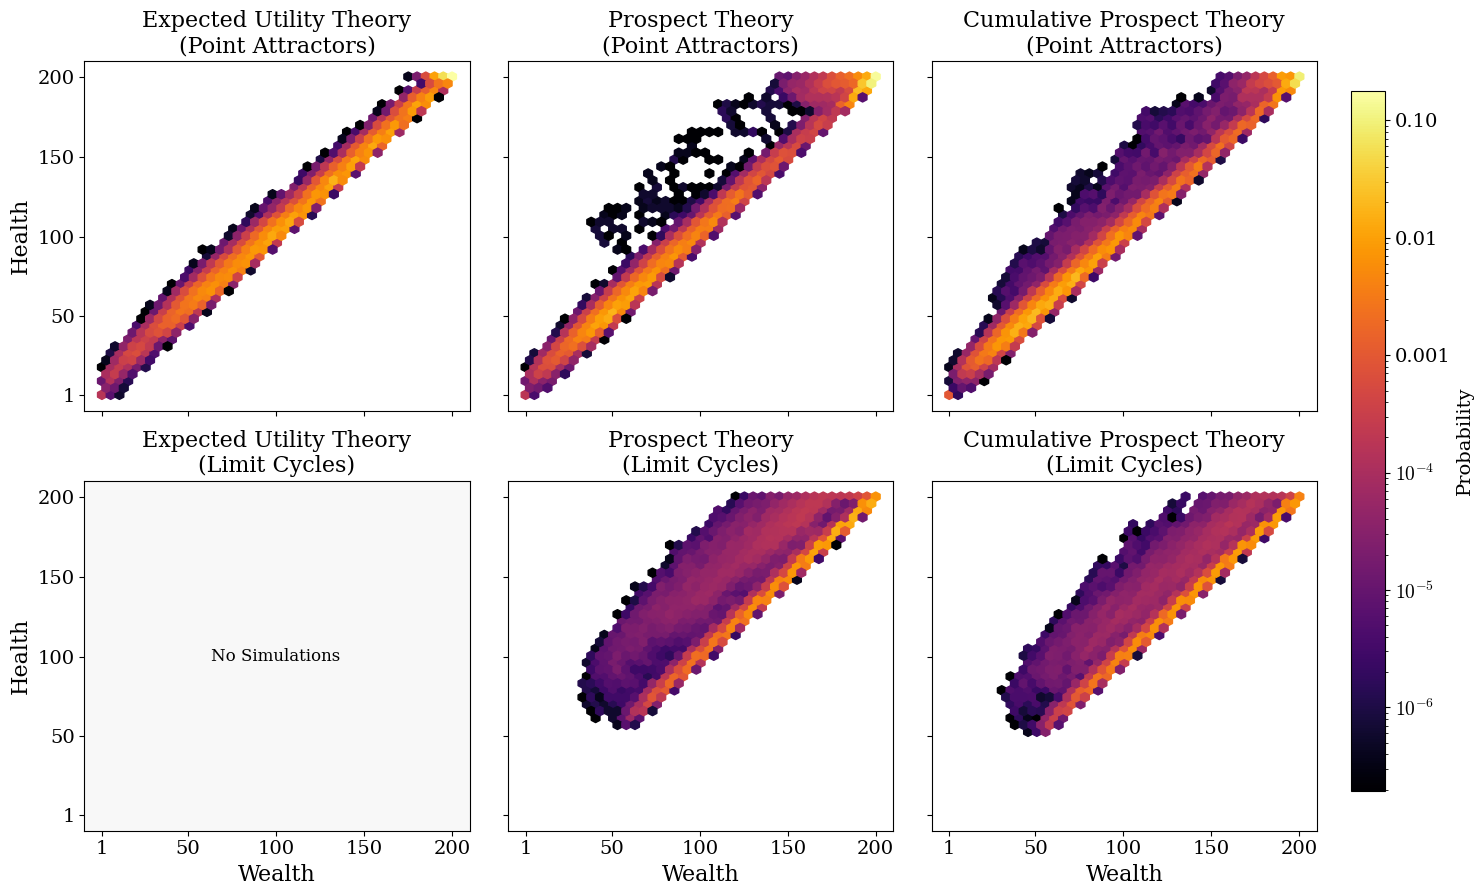

In [ ]:
num_bins = 40
AMP_THRESHOLD = 5

# 1. PRE-CALCULATE GLOBAL LIMITS
global_min_prob = 1.0
global_max_prob = 0.0
plot_data_cache = { 'row1': [], 'row2': [] } 

for model in models:
    all_items = data_storage[model]
    total_points = sum(len(item[0]) for item in all_items)
    if total_points == 0: total_points = 1
    
    current_min_quantum = 1.0 / total_points
    if current_min_quantum < global_min_prob:
        global_min_prob = current_min_quantum

    # --- Process Row 1 ---
    filt_items_1 = [item for item in all_items if item[2] < AMP_THRESHOLD]
    if filt_items_1:
        w = np.concatenate([item[0] for item in filt_items_1])
        h = np.concatenate([item[1] for item in filt_items_1])
        weights = np.ones_like(w) / total_points
        H, _, _ = np.histogram2d(w, h, bins=num_bins, range=[[0, N], [0, N]], weights=weights)
        if H.max() > global_max_prob: global_max_prob = H.max()
        plot_data_cache['row1'].append((w, h, weights))
    else:
        plot_data_cache['row1'].append(None)

    # --- Process Row 2 ---
    filt_items_2 = [item for item in all_items if item[2] >= AMP_THRESHOLD]
    if filt_items_2:
        w = np.concatenate([item[0] for item in filt_items_2])
        h = np.concatenate([item[1] for item in filt_items_2])
        weights = np.ones_like(w) / total_points
        H, _, _ = np.histogram2d(w, h, bins=num_bins, range=[[0, N], [0, N]], weights=weights)
        if H.max() > global_max_prob: global_max_prob = H.max()
        plot_data_cache['row2'].append((w, h, weights))
    else:
        plot_data_cache['row2'].append(None)

if global_max_prob == 0: global_max_prob = 1.0

# Define the Shared Norm
shared_norm = mcolors.LogNorm(vmin=global_min_prob, vmax=global_max_prob)

# 2. PLOTTING
fig, axes = plt.subplots(2, 3, figsize=(17, 10), sharex=True, sharey=True)
titles = ["Expected Utility Theory", "Prospect Theory", "Cumulative Prospect Theory"]

plt.subplots_adjust(right=0.85, wspace=0.1, hspace=0.2)

for i, model in enumerate(models):
    # --- Row 1 ---
    ax = axes[0, i]
    data = plot_data_cache['row1'][i]
    if data is not None:
        w, h, weights = data
        hb = ax.hexbin(w, h, C=weights, reduce_C_function=np.sum,
                       gridsize=num_bins, cmap='inferno', norm=shared_norm,
                       extent=[1, N, 1, N], mincnt=1)
    else:
        ax.text(100, 100, "No Point Attractors", ha='center', va='center')
    ax.set_title(f"{titles[i]}\n(Point Attractors)", fontsize=16)

    # --- Row 2 ---
    ax = axes[1, i]
    data = plot_data_cache['row2'][i]
    if data is not None:
        w, h, weights = data
        hb = ax.hexbin(w, h, C=weights, reduce_C_function=np.sum,
                       gridsize=num_bins, cmap='inferno', norm=shared_norm,
                       extent=[1, N, 1, N], mincnt=1)
    else:
        ax.text(100, 100, "No Simulations", ha='center', va='center', fontsize=12)
        ax.set_facecolor("#f0f0f067")
    ax.set_title(f"{titles[i]}\n(Limit Cycles)", fontsize=16)
    ax.set_xlabel("Wealth")

axes[0,0].set_ylabel("Health")
axes[1,0].set_ylabel("Health")

# --- SET TICKS EXPLICITLY ---
ticks = [1, 50, 100, 150, 200]
for ax in axes.flat:
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

# 3. CREATE SHARED COLORBAR
sm = plt.cm.ScalarMappable(cmap='inferno', norm=shared_norm)
sm.set_array([]) 
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7]) 

# --- UPDATED FORMATTER ---
def decimal_formatter(x, pos):
    # For very small probabilities, use 10^-x notation
    if x < 0.001:
        s = f'{x:.0e}' # e.g. "1e-05"
        base, exponent = s.split('e')
        # If the number is exactly 1*10^-x, return 10^-x
        if float(base) == 1.0:
            return r'$10^{{{}}}$'.format(int(exponent))
        # Otherwise return standard scientific e.g. 2e-5
        return s 
        
    # For larger probabilities, keep decimal
    if x < 0.01:  return f'{x:.3f}'
    return f'{x:.2f}'

cb = fig.colorbar(sm, cax=cbar_ax, format=ticker.FuncFormatter(decimal_formatter))
cb.set_label('Probability', fontsize=14)

plt.show()

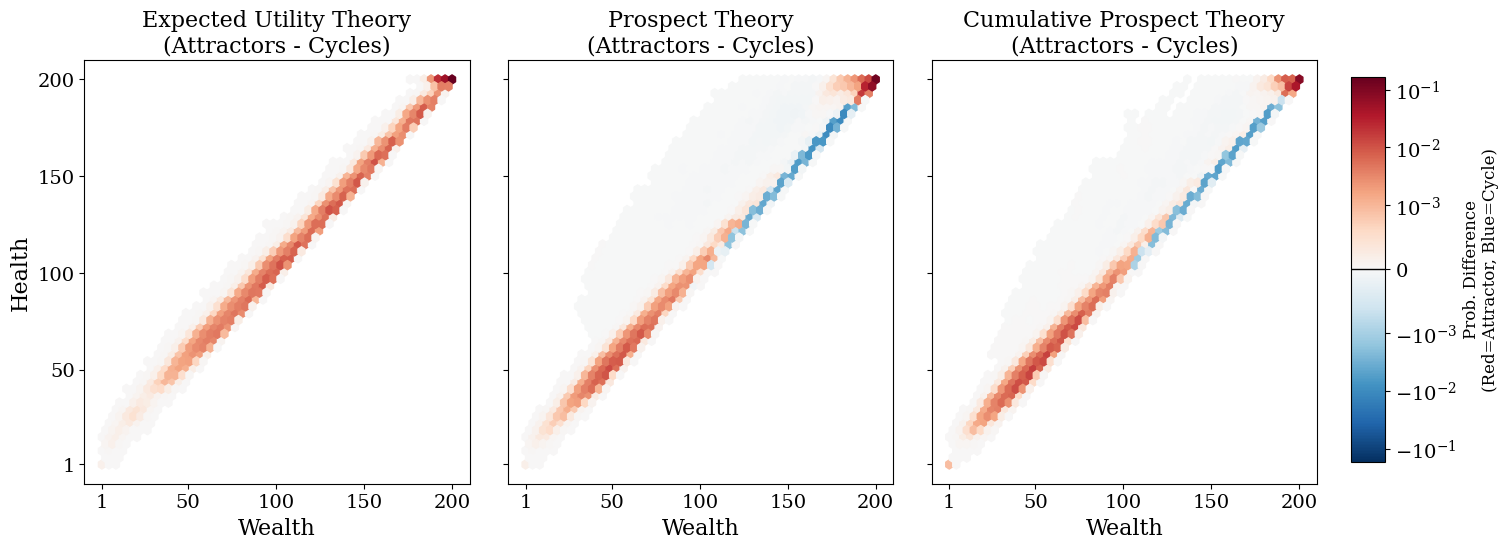

In [116]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import numpy as np

# --- SETTINGS ---
num_bins = 50
AMP_THRESHOLD = 5

# 1. PRE-CALCULATE DATA & LIMITS
max_abs_diff = 0.0
diff_data_cache = []

for model in models:
    all_items = data_storage[model]
    total_points = sum(len(item[0]) for item in all_items)
    if total_points == 0: total_points = 1
    
    w_combined = []
    h_combined = []
    weights_combined = []
    
    # Positive Weights (Attractors)
    filt_attractors = [item for item in all_items if item[2] < AMP_THRESHOLD]
    if filt_attractors:
        w = np.concatenate([item[0] for item in filt_attractors])
        h = np.concatenate([item[1] for item in filt_attractors])
        w_combined.append(w)
        h_combined.append(h)
        weights_combined.append(np.ones_like(w) / total_points)

    # Negative Weights (Cycles)
    filt_cycles = [item for item in all_items if item[2] >= AMP_THRESHOLD]
    if filt_cycles:
        w = np.concatenate([item[0] for item in filt_cycles])
        h = np.concatenate([item[1] for item in filt_cycles])
        w_combined.append(w)
        h_combined.append(h)
        weights_combined.append(np.ones_like(w) * (-1.0 / total_points))

    if w_combined:
        full_w = np.concatenate(w_combined)
        full_h = np.concatenate(h_combined)
        full_weights = np.concatenate(weights_combined)
        
        # Estimate range
        H, _, _ = np.histogram2d(full_w, full_h, bins=num_bins, 
                                 range=[[0, N], [0, N]], weights=full_weights)
        
        current_max = np.max(np.abs(H))
        if current_max > max_abs_diff:
            max_abs_diff = current_max
            
        diff_data_cache.append((full_w, full_h, full_weights))
    else:
        diff_data_cache.append(None)

if max_abs_diff == 0: max_abs_diff = 0.1


# --- THE FIX: SYMMETRICAL LOG NORM ---
# linthresh: The range within which the plot is linear (to avoid log(0)).
# Any value < 0.001 is linear (white). Any value > 0.001 is Logarithmic (Blue/Red).
# Reducing linthresh makes small values pop more.
norm_diff = mcolors.SymLogNorm(linthresh=0.001, linscale=1, 
                               vmin=-max_abs_diff, vmax=max_abs_diff, base=10)


# 2. PLOTTING
fig, axes = plt.subplots(1, 3, figsize=(17, 5.5), sharex=True, sharey=True)
titles = ["Expected Utility Theory", "Prospect Theory", "Cumulative Prospect Theory"]

plt.subplots_adjust(right=0.85, wspace=0.1)

for i, model in enumerate(models):
    ax = axes[i]
    data = diff_data_cache[i]
    
    if data is not None:
        w, h, weights = data
        
        hb = ax.hexbin(w, h, 
                       C=weights,
                       reduce_C_function=np.sum,
                       gridsize=num_bins, 
                       cmap='RdBu_r', 
                       norm=norm_diff,  # <--- Applied here
                       extent=[1, N, 1, N], 
                       mincnt=None)
    else:
        ax.text(100, 100, "No Data", ha='center', va='center')
        ax.set_facecolor("#f0f0f067")

    ax.set_title(f"{titles[i]}\n(Attractors - Cycles)", fontsize=16)
    ax.set_xlabel("Wealth")

axes[0].set_ylabel("Health")

# --- SET TICKS ---
ticks = [1, 50, 100, 150, 200]
for ax in axes.flat:
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

# 3. CREATE COLORBAR
sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=norm_diff)
sm.set_array([]) 

cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7]) 
cb = fig.colorbar(sm, cax=cbar_ax)
cb.set_label('Prob. Difference\n(Red=Attractor, Blue=Cycle)', fontsize=12)
cb.ax.hlines(0, -1, 1, colors='k', linewidth=1) 

plt.show()